In [1]:
import os

import cv2


DATA_DIR = './data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

number_of_classes = 27
dataset_size = 100

cap = cv2.VideoCapture(1)
for j in range(number_of_classes):
    path = 'Y'
    if not os.path.exists(os.path.join(DATA_DIR, path)):
        os.makedirs(os.path.join(DATA_DIR, path))

    print('Collecting data for class {}'.format(j))

    done = False
    while True:
        ret, frame = cap.read()
        cv2.putText(frame, 'Ready? Press "Q" ! :)', (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3,
                    cv2.LINE_AA)
        cv2.imshow('frame', frame)
        if cv2.waitKey(25) == ord('q'):
            break

    counter = 0
    while counter < dataset_size:
        ret, frame = cap.read()
        cv2.imshow('frame', frame)
        cv2.waitKey(25)
        cv2.imwrite(os.path.join(DATA_DIR, path, '{}.jpg'.format(counter)), frame)

        counter += 1

cap.release()
cv2.destroyAllWindows()

In [1]:
import os
import pickle
import numpy as np
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt


mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.1)

DATA_DIR = 'data'

data = []
labels = []
for dir_ in os.listdir(DATA_DIR)[1:]:
    
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_)):
        
        data_aux = []
        x_s = []
        y_s = []
        
        img = cv2.imread(os.path.join(DATA_DIR, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        results = hands.process(img_rgb)
        
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y

                    x_s.append(x)
                    y_s.append(y)

                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    
                    data_aux.append(x - min(x_s))
                    data_aux.append(y - min(y_s))
                    
            if len(data_aux)==42:
                data.append(data_aux)
                labels.append(dir_)


I0000 00:00:1712801102.732118       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = np.asarray(data)
labels = np.asarray(labels)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

model = RandomForestClassifier(criterion = 'log_loss')

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

score = accuracy_score(y_pred, y_test)

print('{}% of samples were classified correctly'.format(score * 100))

99.22330097087378% of samples were classified correctly


Confusion matrix


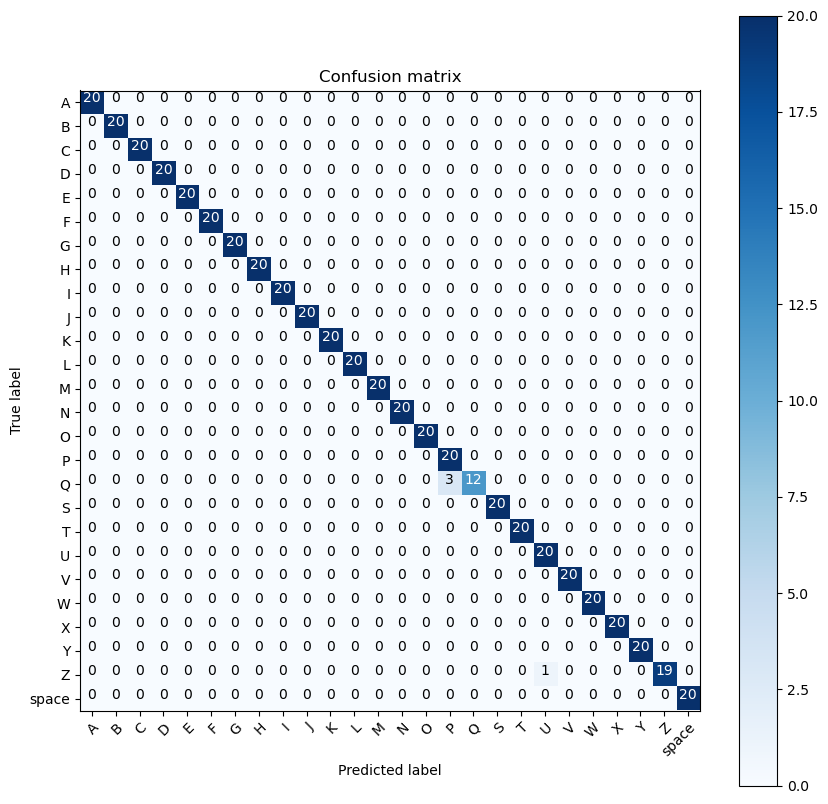

In [3]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, rotation_mode='anchor', ha = 'right')
    plt.yticks(tick_marks, classes)

    
    print('Confusion matrix')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)
label_set = np.unique(labels)
plot_confusion_matrix(cnf_matrix, label_set,
                      title='Confusion matrix')

In [4]:
f = open('model.p', 'wb')
pickle.dump({'model': model}, f)
f.close()